In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ReduceLROnPlateau

In [32]:
# class CustomCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         print(f"Epoch {epoch + 1}/{self.params['epochs']} - "
#               f"loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - "
#               f"val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

# pd.set_option('display.max_columns', None)

In [33]:
train = pd.read_csv("data/train.csv", index_col="id")
train.head(5)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


### Pre-processing

In [34]:
Categorical = ["Marital status", 
               "Application mode", 
               "Application order", 
               "Course", 
               "Previous qualification", 
               "Nacionality", 
               "Mother's qualification", 
               "Father's qualification", 
               "Mother's occupation", 
               "Father's occupation"]
Boolean = ["Daytime/evening attendance", 
           "Displaced", 
           "Educational special needs", 
           "Debtor", 
           "Tuition fees up to date", 
           "Gender", 
           "Scholarship holder", 
           "International" ]
Continuous = ["Previous qualification (grade)", 
              "Admission grade", 
              "Age at enrollment", 
              "Curricular units 1st sem (credited)", 
              "Curricular units 1st sem (enrolled)", 
              "Curricular units 1st sem (evaluations)", 
              "Curricular units 1st sem (approved)", 
              "Curricular units 1st sem (grade)", 
              "Curricular units 1st sem (without evaluations)",
              "Curricular units 2nd sem (credited)", 
              "Curricular units 2nd sem (enrolled)", 
              "Curricular units 2nd sem (evaluations)", 
              "Curricular units 2nd sem (approved)", 
              "Curricular units 2nd sem (grade)", 
              "Curricular units 2nd sem (without evaluations)",
              "Unemployment rate",
              "Inflation rate",
              "GDP"]

In [35]:
# One-hot encode categorical columns
train = pd.get_dummies(train, columns=Categorical)

# Scale continuous columns
train[Continuous] = (train[Continuous] - train[Continuous].mean()) / train[Continuous].std()

# Separate features and target
X = train.drop('Target', axis=1)
y = train['Target']

# One-hot encode the target variable if it is categorical
y = pd.get_dummies(y)

### Modelling

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [51]:
# Define CustomLogger callback outside of my_train function
class CustomLogger(Callback):
    def __init__(self):
        super(CustomLogger, self).__init__()
        self.epoch_times = []
        self.total_start_time = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self.epoch_start_time)
        if (epoch + 1) % 10 == 0:
            lr = self.model.optimizer.learning_rate.numpy()
            print(f"Epoch {epoch+1}: Learning Rate = {lr:.6f}, "
                  f"Train Loss = {logs['loss']:.3f}, Train Acc = {logs['accuracy']:.3f}, "
                  f"Val Loss = {logs['val_loss']:.3f}, Val Acc = {logs['val_accuracy']:.3f}, "
                  f"Time per Epoch = {self.epoch_times[-1]:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.total_start_time
        print(f"Total training time: {total_time:.2f} seconds")

def my_train(units_per_layer, initial_learning_rate, decay_factor, patience, lambda_reg, dropout_rate, num_epochs):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    num_hidden_layers = len(units_per_layer)
    for i, units in enumerate(units_per_layer, start=1):
        if i < num_hidden_layers:
            model.add(Dense(units, activation='tanh', kernel_regularizer=l2(lambda_reg), name=f'Hidden_Layer_{i}'))
            model.add(Dropout(dropout_rate, name=f'Dropout_{i}'))  # Adding dropout after each hidden layer except the last one
        else:
            model.add(Dense(units, activation='tanh', kernel_regularizer=l2(lambda_reg), name=f'Hidden_Layer_{i}'))
    model.add(Dense(3, activation='softmax', name="output_layer"))  # For multi-class classification with 3 classes

    # Compile the model with Adam optimizer and initial learning rate
    model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()

    # Define a learning rate scheduler (ReduceLROnPlateau)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=decay_factor, patience=patience, min_lr=1e-7)

    # Define CustomLogger callback
    custom_logger = CustomLogger()

    # Fit the model for specified number of epochs with verbose=0 to disable unnecessary logging
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=64, validation_data=(X_val, y_val),
                        callbacks=[custom_logger, lr_scheduler], verbose=0)

    return history

def plot_history(history):
    # Plot training & validation accuracy and loss
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)               │ (None, 25)                  │           7,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_2 (Dense)               │ (None, 20)                  │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_3 (Dense)               │ (None, 15)                  │             315 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_4 (Dense)               │ (None, 10)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_4 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_5 (Dense)               │ (None, 6)                   │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 3)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,357 (32.64 KB)

 Trainable params: 8,357 (32.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 10: Learning Rate = 0.005000, Train Loss = 0.479, Train Acc = 0.823, Val Loss = 0.490, Val Acc = 0.822, Time per Epoch = 0.91 seconds
Epoch 20: Learning Rate = 0.004000, Train Loss = 0.472, Train Acc = 0.824, Val Loss = 0.481, Val Acc = 0.821, Time per Epoch = 0.91 seconds
Epoch 30: Learning Rate = 0.002560, Train Loss = 0.464, Train Acc = 0.827, Val Loss = 0.473, Val Acc = 0.825, Time per Epoch = 0.92 seconds
Epoch 40: Learning Rate = 0.002560, Train Loss = 0.463, Train Acc = 0.825, Val Loss = 0.475, Val Acc = 0.825, Time per Epoch = 0.94 seconds
Epoch 50: Learning Rate = 0.002048, Train Loss = 0.460, Train Acc = 0.827, Val Loss = 0.469, Val Acc = 0.825, Time per Epoch = 0.94 seconds
Epoch 60: Learning Rate = 0.001311, Train Loss = 0.454, Train Acc = 0.828, Val Loss = 0.466, Val Acc = 0.825, Time per Epoch = 0.95 seconds
Epoch 70: Learning Rate = 0.001049, Train Loss = 0.453, Train Acc = 0.828, Val Loss = 0.463, Val Acc = 0.825, Time per Epoch = 0.94 seconds
Epoch 80: Learning R

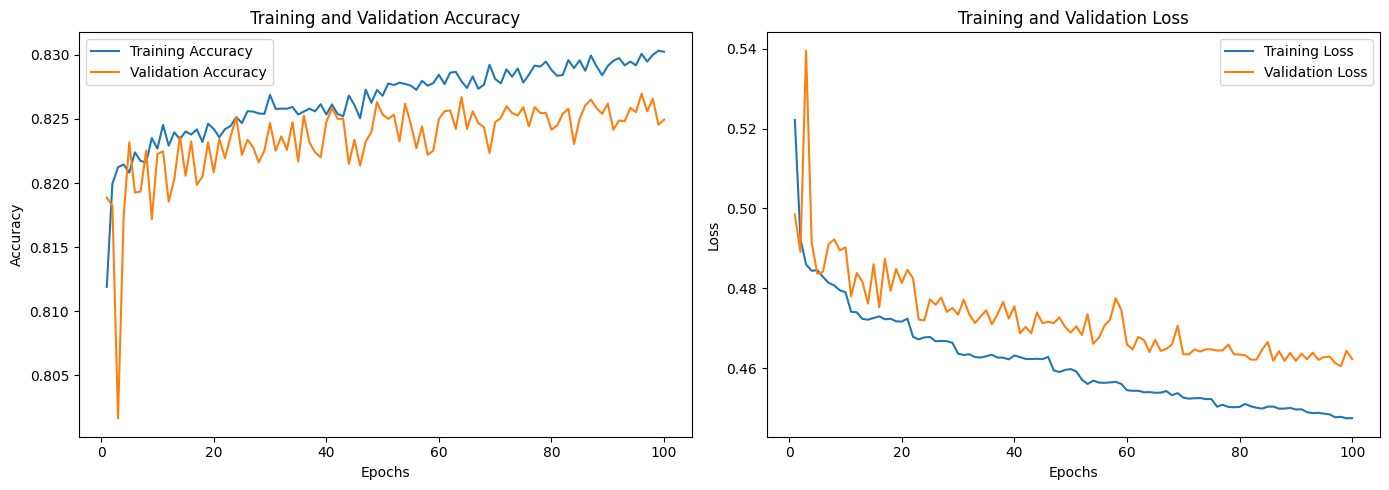

In [54]:
# Example usage directly passing parameters to my_train function
history = my_train(
    units_per_layer=[25, 20, 15, 10, 6],
    initial_learning_rate=0.005,
    decay_factor=0.8,
    patience=5,
    lambda_reg=0.0005,
    dropout_rate=0.0,
    num_epochs=100
)

plot_history(history)

TO DO: Get a proper over-fit. THEN reguralise. Dropout?

Embed target as -1, 0, 1